# Прогнозирование отмены бронирования отеля

Заказчик этого исследования — сеть отелей «Как в гостях». 
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.


## Бизнес-метрики и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 
Стоимость номеров отеля:
* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## Описание данных

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:
* `id` — номер записи;
* `adults` — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type` — тип заказчика:
* `Contract` — договор с юридическим лицом;
* `Group` — групповой заезд;
* `Transient` — не связано с договором или групповым заездом;
* `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_canceled` — отмена заказа, **целевой признак**;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:
  * `SC` — нет дополнительных опций;
  * `BB` — включён завтрак;
  * `HB` — включён завтрак и обед;
  * `FB` — включён завтрак, обед и ужин.
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type` — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

## Импорты и константы 

In [1]:
import os
import pandas as pd
import numpy as np
from math import ceil

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, classification_report

from catboost import CatBoostClassifier, Pool, cv

from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

In [2]:
SPRING_FALL_COEFF = 1.2
SUMMER_COEFF = 1.4
SYS_BUDGET = 400000
DEPOSIT_COEFF = 0.8
RANDOM_STATE = 12345

night_cost_dict = {'A':1000,'B':800,'C':600,'D':550,'E':500,'F':450,'G':350}
service_dict = {'A':400,'B':350,'C':350,'D':150,'E':150,'F':150,'G':150}

## Изучение и предобработка данных

In [3]:
try:
    df_train = pd.read_csv('/home/aart/datasets/hotel_train.csv')
    df_test = pd.read_csv('/home/aart/datasets/hotel_test.csv')
except:
    df_train = pd.read_csv('/datasets/hotel_train.csv')
    df_test = pd.read_csv('/datasets/hotel_test.csv')
    
dfs = [df_train, df_test]

In [4]:
display(df_train.head(),df_test.head())
print('Размер тренировочного датафрейма:', df_train.shape)
print('Размер тестового датафрейма:', df_test.shape)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


Размер тренировочного датафрейма: (65229, 25)
Размер тестового датафрейма: (32412, 25)


### Дубликаты и пропуски

Проверка на явные дубликаты:

In [5]:
print('Явных полных дубликатов в тренировочном датасете:', df_train.duplicated().sum())
print('Явных полных дубликатов в тестовом датасете:', df_test.duplicated().sum())

Явных полных дубликатов в тренировочном датасете: 0
Явных полных дубликатов в тестовом датасете: 0


Проверка на пропуски:

In [11]:
print('Пропусков в тренировочном датасете:', df_train.isna().sum().sum())
print('Пропусков в тестовом датасете:', df_test.isna().sum().sum())

Пропусков в тренировочном датасете: 0
Пропусков в тестовом датасете: 0


### Выбросы

In [12]:
display(df_train.describe().T, df_test.describe().T)

,count,mean,std,min,25%,50%,75%,max
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0
babies,65229.0,0.007236,0.098790,0.0,0.0,0.0,0.0,10.0


,count,mean,std,min,25%,50%,75%,max
is_canceled,32412.0,0.388467,0.487409,0.0,0.0,0.0,1.0,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.0,76.0,155.0,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.0,2017.0,2017.0,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.0,18.0,25.0,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.0,15.5,23.0,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.0,2.0,3.0,6.0
adults,32412.0,1.858602,0.489341,0.0,2.0,2.0,2.0,4.0
children,32412.0,0.083765,0.343470,0.0,0.0,0.0,0.0,3.0
babies,32412.0,0.005523,0.075757,0.0,0.0,0.0,0.0,2.0


In [13]:
target = 'is_cancelled'
numerical_features = ['lead_time','stays_in_weekend_nights','arrival_date_week_number','arrival_date_day_of_month',
                      'stays_in_week_nights','adults','children',
                      'babies','previous_cancellations','previous_bookings_not_canceled','booking_changes',
                      'days_in_waiting_list','required_car_parking_spaces','total_of_special_requests',
                      'total_nights']

categorial_features = ['arrival_date_year', 'arrival_date_month', 'is_repeated_guest', 'meal', 'country', 
                       'distribution_channel','reserved_room_type', 'customer_type']

Строим гистограммы для тестовой выборки.

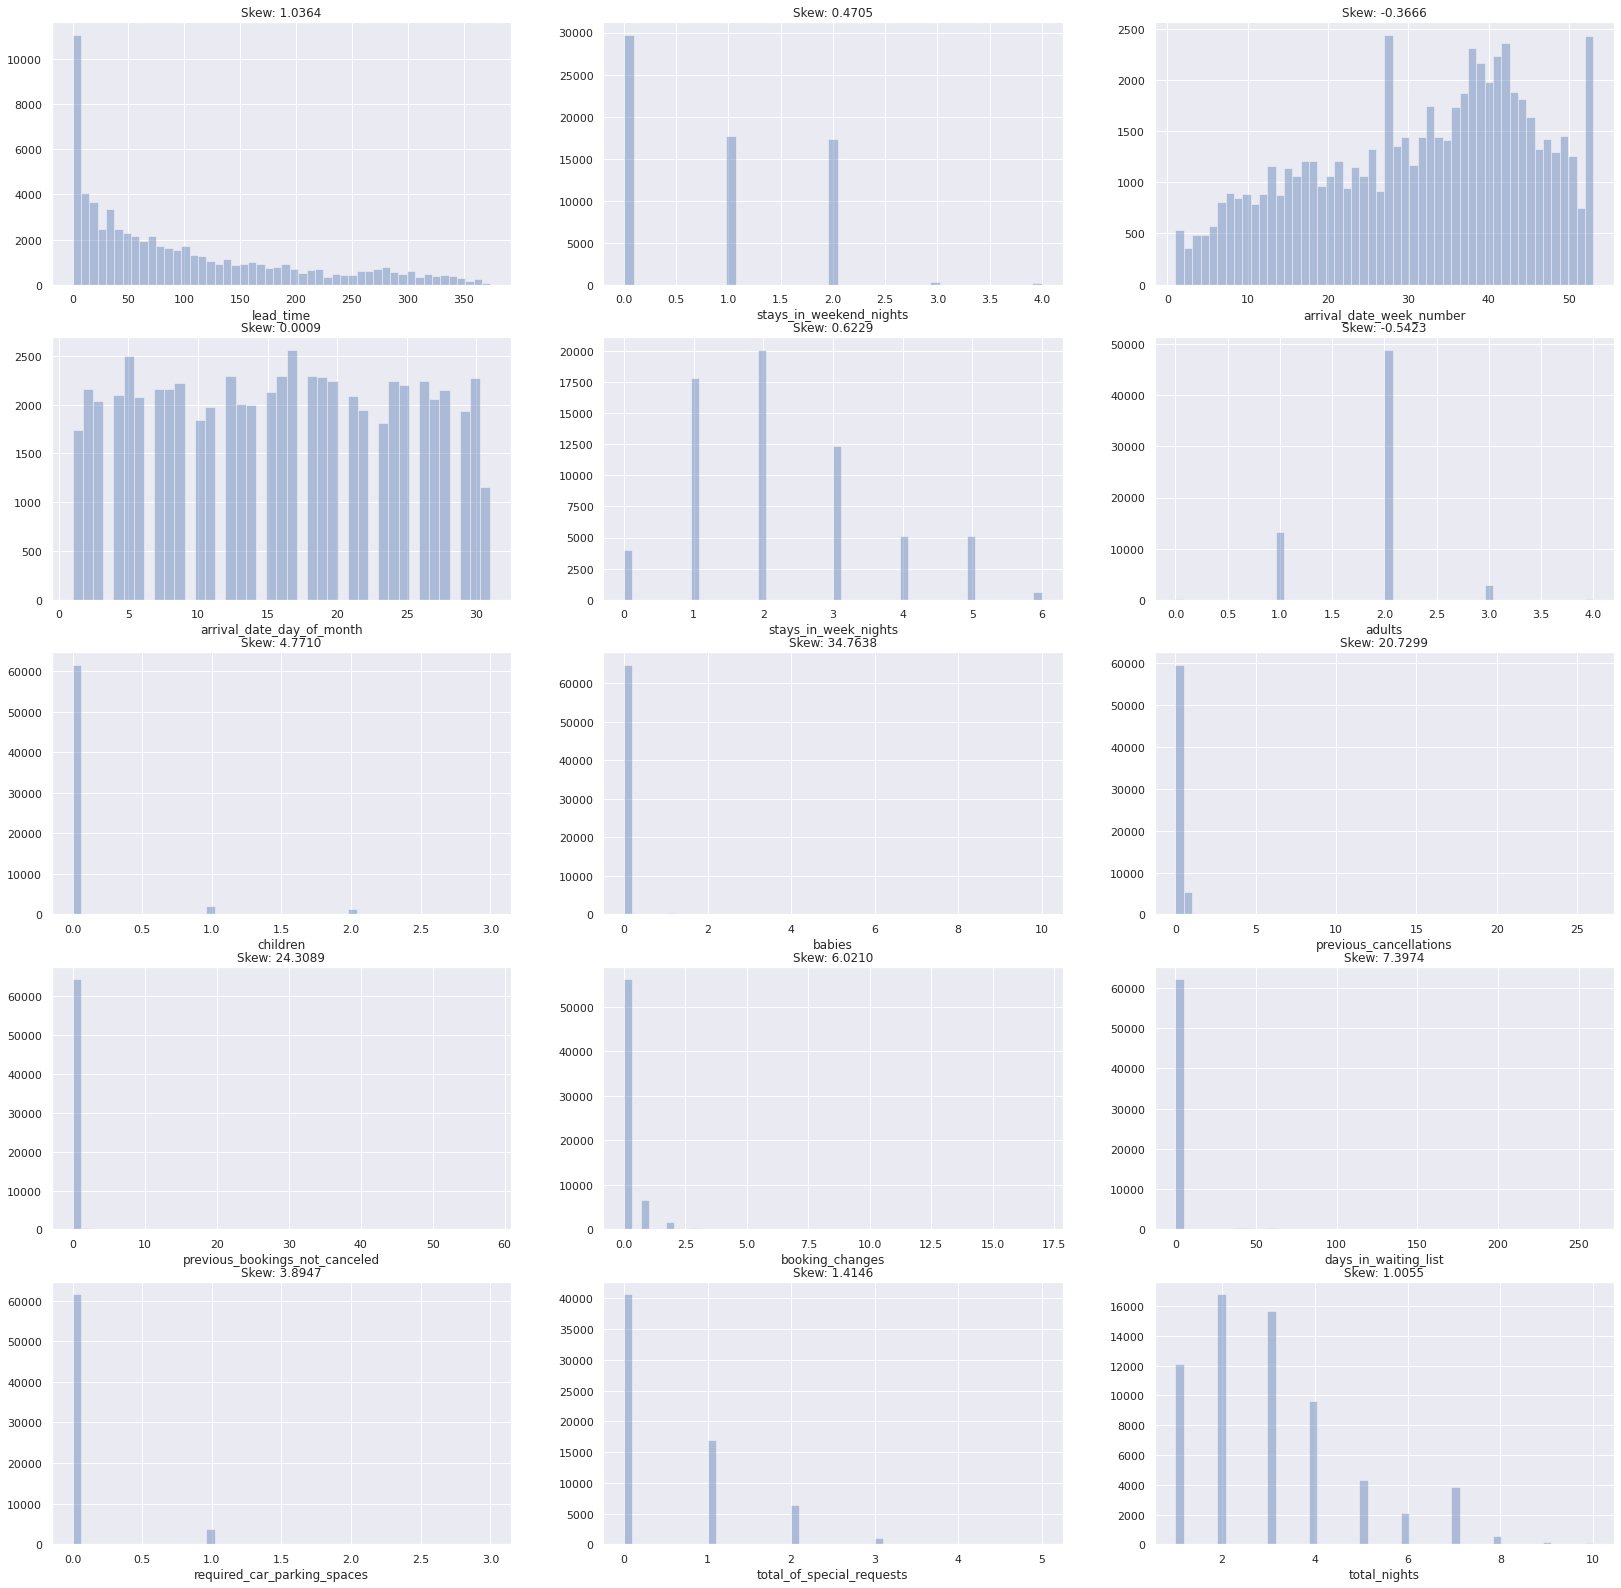

In [14]:
f, a = plt.subplots(5,3, figsize=(28,28))
a = a.flatten().T
for i, col in enumerate(df_train[numerical_features].columns):
    sns.distplot(df_train[col],ax=a[i],kde=False).set_title('Skew: {:.4f}'.format(df_train[col].skew()))
plt.show();

Распределения напоминают пуассоновские, описываются бизнес-метрики, так что будем судить о распределениях именно как о распределениях Пуассона при поиске выбросов.

Построим probplot'ы для вычисления выбросов, ассиметрии, эксцессов

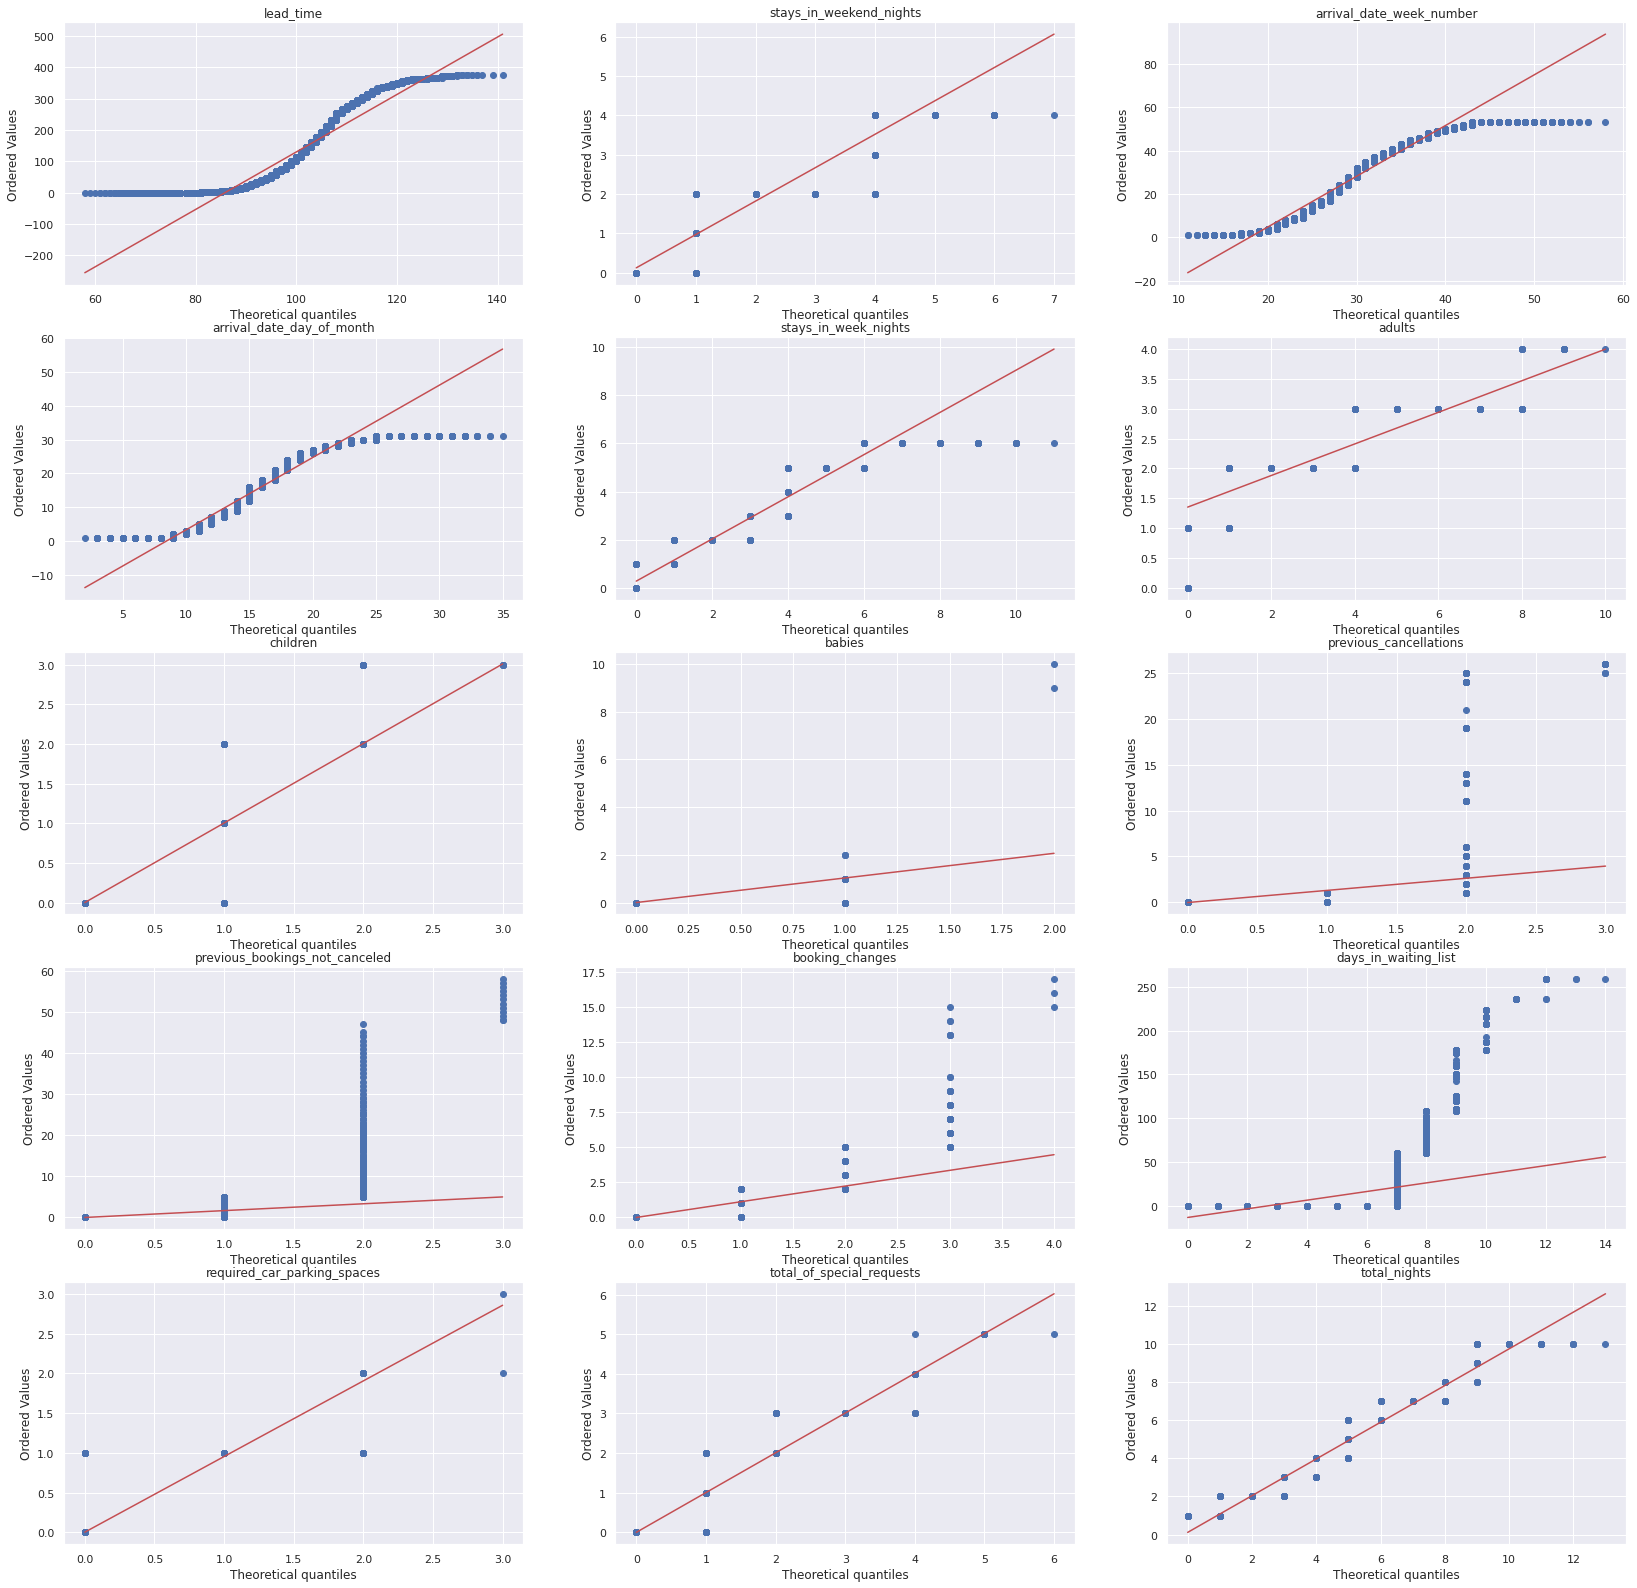

In [15]:
f, a = plt.subplots(5,3, figsize=(28,28))
a = a.flatten().T
for i, col in enumerate(df_train[numerical_features].columns):
    st.probplot(df_train[col], plot=a[i], dist='poisson', sparams=(df_train[col].mean()))
    a[i].set_title(col)
plt.show()

Предположим, что наши данные должны быть пуассоновски распределены. Изучая значения на графиках вероятности, мы можем увидеть, что существуют значения, которые ответственны за отклонение от вышеупопянутого распределения.
Таким образом, можно "придираться" к значениям из визуализаций, классифицировать их как выбросы и обрабатывать соответствующим образом.
При таком подходе выбросами являются, например:
* значения больше ~2.5 для признака `previous_cancellations`
* значения больше 5 для признака `booking_changes`
* и т.д.

Масштабировать данные можно разными способами. В данном исследовании опробуем robust scaler. RobustScaler использует интерквантильные размахи, так что при OHE данные масштабированные RobustScaler'ом менее уязвимы к выбросам.

### Мультиколлинеарность

Изучим матрицу корреляций в виде clustermap'a для тренировочного датафрейма.

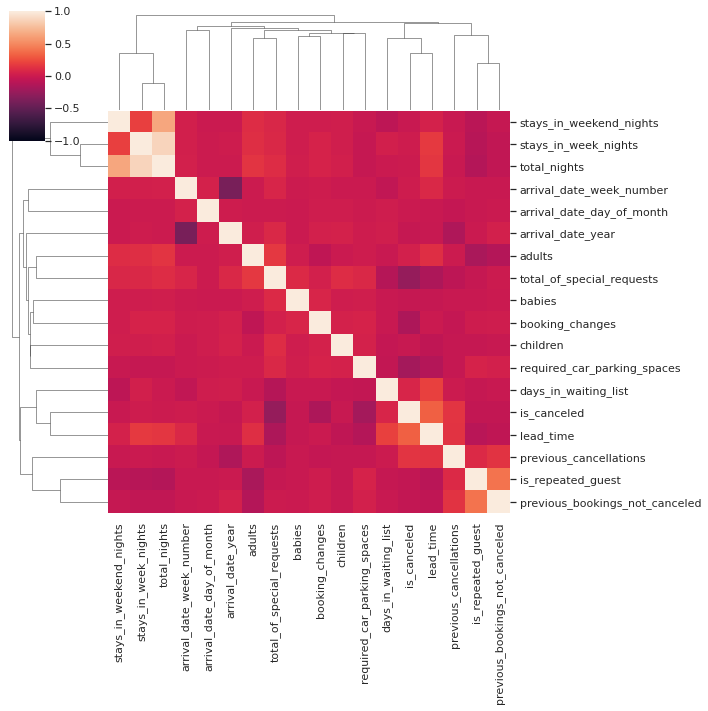

In [16]:
sns.clustermap(df_train.corr(), vmin=-1, vmax=1, annot=False);

Существует структурная мультиколлинеарность признаков, описывающих пребывание в будние/выходные дни и общее количество дней.
Оценим variance inflation factor

In [17]:
X_vif = df_train[['stays_in_week_nights','total_nights']]

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns

vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]
print(vif_data)

                Feature        VIF
0  stays_in_week_nights  15.770057
1          total_nights  15.770057


Значение VIF>15 высоко и надлежит корректировке.

### Баланс классов

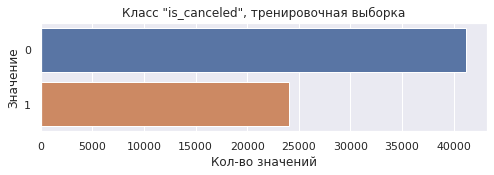

In [18]:
plt.figure(figsize=(8,2))
sns.countplot(data = df_train, y='is_canceled')
plt.title('Класс "is_canceled", тренировочная выборка')
plt.xlabel('Кол-во значений')
plt.ylabel('Значение');

In [19]:
print('Доли значений:')
df_train['is_canceled'].value_counts() / len(df_train)

Доли значений:


0    0.631391
1    0.368609
Name: is_canceled, dtype: float64

Бороться с дисбалансом можно так же по-разному: ап- и даунсемплингом, или взвешиванием. В этом исследовании используем взвешивание.

### Столбец `country` и OneHotEncoder

В столбце `country` в тренировочной выборке есть страны, которых нет в тестовой выборке. Это станет проблемой с OneHotEncoding'ом.

In [20]:
df_train.country.value_counts().head()

PRT    28831
FRA     5974
GBR     5109
ESP     4900
DEU     3887
Name: country, dtype: int64

In [21]:
df_test.country.value_counts().head()

PRT    9887
GBR    3927
FRA    3477
DEU    2378
ESP    1932
Name: country, dtype: int64

Топ-5 стран в обоих выборках совпадает. Кажется целесообразным оставить их как есть, остальные заменить на `other`

In [22]:
top_five = ['PRT','GBR','FRA','DEU','ESP']
df_train.loc[~df_train["country"].isin(top_five), "country"] = "OTHER"
df_test.loc[~df_test["country"].isin(top_five), "country"] = "OTHER"

### Итоги

In [23]:
X_train = df_train.drop([
    'is_canceled', #Целевой
    'arrival_date_year', #Бесполезные фичи
    'arrival_date_week_number', 
    'arrival_date_day_of_month', 
    'stays_in_week_nights', #VIF
    ], axis=1)

y_train = df_train.is_canceled

X_test = df_test.drop([
    'is_canceled', #Целевой
    'arrival_date_year', #Бесполезный
    'arrival_date_week_number', #Бесполезные фичи
    'arrival_date_day_of_month', 
    'stays_in_week_nights', #VIF
    ], axis=1)

y_test = df_test.is_canceled

In [24]:
#OHE для линейных моделей
encoder_eligible = ['arrival_date_month',
    'meal',
    'distribution_channel',
    'reserved_room_type',
    'customer_type',
    'country']

ohe = OneHotEncoder(drop='first', dtype='int')
ohe.fit(X_train[encoder_eligible])

X_train_ohe = pd.DataFrame(
    ohe.transform(X_train[encoder_eligible]
    ).toarray()).astype('category')
X_train_ohe = X_train.join(X_train_ohe)
X_train_ohe = X_train_ohe.drop(encoder_eligible, axis=1)

X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[encoder_eligible]
    ).toarray()).astype('category')
X_test_ohe = X_test.join(X_test_ohe)
X_test_ohe = X_test_ohe.drop(encoder_eligible, axis=1)

In [25]:
#OE для деревьев
encoder = OrdinalEncoder(dtype='int')
encoder.fit(X_train[encoder_eligible])

X_train[encoder_eligible] = encoder.transform(
    X_train[encoder_eligible]
    ).astype('str')
X_test[encoder_eligible] = encoder.transform(
    X_test[encoder_eligible]
    ).astype('str')

In [26]:
#scaler
num_features_for_scaler = ['lead_time','stays_in_weekend_nights',
                      'adults','children',
                      'babies','previous_cancellations','previous_bookings_not_canceled','booking_changes',
                      'days_in_waiting_list','required_car_parking_spaces','total_of_special_requests',
                      'total_nights']

scaler = RobustScaler()
scaler_ohe = RobustScaler()

scaler.fit(X_train[num_features_for_scaler])
scaler_ohe.fit(X_train_ohe[num_features_for_scaler])

X_train[num_features_for_scaler] = scaler.transform(X_train[num_features_for_scaler])
X_test[num_features_for_scaler] = scaler.transform(X_test[num_features_for_scaler])
X_train_ohe[num_features_for_scaler] = scaler_ohe.transform(X_train_ohe[num_features_for_scaler])
X_test_ohe[num_features_for_scaler] = scaler_ohe.transform(X_test_ohe[num_features_for_scaler])

## Вычисление прибыли до внедрения модели

Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

In [27]:
def revenue(row):
    if row['is_canceled']==1:
        revenue=0
    elif row['arrival_date_month'] in ['June','July','August']:
        revenue= night_cost_dict[row['reserved_room_type']]*row['total_nights']*SUMMER_COEFF
    elif row['arrival_date_month'] in ['March','April','May','September','October','November']:
        revenue = night_cost_dict[row['reserved_room_type']]*row['total_nights']*SPRING_FALL_COEFF
    else:
        revenue = night_cost_dict[row['reserved_room_type']]*row['total_nights']
    return revenue

def losses(row):
    if row['is_canceled']==1:
        losses = service_dict[row['reserved_room_type']]
        if row['arrival_date_month'] in ['June','July','August']:
            losses = losses + night_cost_dict[row['reserved_room_type']]*SUMMER_COEFF
        elif row['arrival_date_month'] in ['March','April','May','September','October','November']:
            losses = losses + night_cost_dict[row['reserved_room_type']]*SPRING_FALL_COEFF
        else:
            losses = losses + night_cost_dict[row['reserved_room_type']]
    else:
        losses = service_dict[row['reserved_room_type']] * (ceil(row['total_nights']/2)+1)
    return losses

In [28]:
df_test.reserved_room_type = df_test.reserved_room_type.str.replace(' ', '')
PROFIT_NO_MODEL = df_test.apply(revenue, axis=1) - df_test.apply(losses, axis=1)
print('Прибыль до внедрения моделей:', PROFIT_NO_MODEL.sum())

Прибыль до внедрения моделей: 28779420.0


## Оценка моделей

Определяющей метрикой для оценки моделей выберем `F1`.

In [29]:
#табличка с метриками
metrics = pd.DataFrame(
    index=['LogReg', 'RanForest', 'Catboost'],
    columns=['F1-score'])

kf = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)

### 1. Log regression

In [30]:
%%time
# подбор гиперпараметров и оценка
# логистической регресии 
lr_grid = {'C': [0.01,0.1,1],
    'solver': ['newton-cg', 'liblinear']}

lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=1)

best_lr_model = GridSearchCV(
    lr_model,
    lr_grid,
    scoring='f1',
    n_jobs=-1,
    cv=kf)

best_lr_model.fit(X_train_ohe, y_train)

CPU times: user 1min 28s, sys: 53.5 s, total: 2min 21s
Wall time: 2min 22s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced', n_jobs=1,
                                          random_state=12345),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1],
                         'solver': ['newton-cg', 'liblinear']},
             scoring='f1')

In [31]:
metrics.loc['LogReg', 'F1-score'] = best_lr_model.best_score_
print(
    'Лучшие параметры для логистической регрессии:',
    best_lr_model.best_params_
    )

Лучшие параметры для логистической регрессии: {'C': 0.1, 'solver': 'liblinear'}


### 2. Random Forest

In [32]:
%%time
# подбор гиперпараметров и оценка
# случайного леса
rf_grid = {'n_estimators': range(100, 300, 50),
    'criterion': ['gini','entropy'],
    'max_depth': range(10, 21, 5),
    'min_samples_split': range(2, 3),
    'min_samples_leaf': range(1, 2)}

rf_model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced')

best_rf_model = GridSearchCV(
    rf_model,
    rf_grid,
    scoring='f1',
    n_jobs=-1,
    cv=kf)

best_rf_model.fit(X_train, y_train)

CPU times: user 9min 48s, sys: 5.68 s, total: 9min 54s
Wall time: 9min 54s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=12345),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(10, 21, 5),
                         'min_samples_leaf': range(1, 2),
                         'min_samples_split': range(2, 3),
                         'n_estimators': range(100, 300, 50)},
             scoring='f1')

In [33]:
metrics.loc['RanForest', 'F1-score'] = best_rf_model.best_score_
print(
    'Лучшие параметры для  рандомного леса:',
    best_rf_model.best_params_
    )

Лучшие параметры для  рандомного леса: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


### 3. CatBoost

Для CatBoost'a переведем некоторые численные признаки в категориальные (количество детей в наличие детей, etc.)

In [34]:
cols = ['children',
    'babies',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'required_car_parking_spaces']

def num_to_cat(df):
    for col in cols:
        df.loc[df[col]>0, col] = 1
        df[col] = df[col].astype('int').astype('str')
    df.rename(
        columns={
            'children': 'has_children',
            'babies': 'has_babies',
            'previous_cancellations': 'has_previous_cancellations',
            'previous_bookings_not_canceled': 'has_previous_bookings_not_canceled',
            'required_car_parking_spaces': 'car_parking_spaces_required'
            },
        inplace=True)
    
num_to_cat(X_train)
num_to_cat(X_test)

In [35]:
X_train['is_repeated_guest'] = X_train['is_repeated_guest'].astype('int')

In [36]:
%%time
# подбор гиперпараметров и оценка
# градиентного бустинга

cat_features = ['arrival_date_month',
    'has_children',
    'has_babies',
    'meal',
    'distribution_channel',
    'is_repeated_guest',
    'has_previous_cancellations',
    'has_previous_bookings_not_canceled',
    'reserved_room_type',
    'customer_type',
    'car_parking_spaces_required']

cat_grid = {
    'depth': [6],
    'iterations': [1000],
    'learning_rate': [.03],
    'l2_leaf_reg': [3]}
#не потянуло у меня гридсерч, оставил все дефолтное

cat_model = CatBoostClassifier(
    od_pval=.01,
    random_state=RANDOM_STATE,
    logging_level='Silent',
    eval_metric='F1',
    cat_features=cat_features,
    auto_class_weights='Balanced')

best_cat_model = GridSearchCV(
    cat_model,
    cat_grid,
    scoring='f1',
    n_jobs=-1,
    cv=kf)

best_cat_model.fit(X_train, y_train)

CPU times: user 7min 18s, sys: 3.44 s, total: 7min 22s
Wall time: 7min 29s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7fedbc89ef10>,
             n_jobs=-1,
             param_grid={'depth': [6], 'iterations': [1000], 'l2_leaf_reg': [3],
                         'learning_rate': [0.03]},
             scoring='f1')

In [37]:
metrics.loc['Catboost', 'F1-score'] = best_cat_model.best_score_
print(
    'Лучшие параметры для catboost',
    best_cat_model.best_params_
    )

Лучшие параметры для catboost {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


In [38]:
metrics

,F1-score
LogReg,0.720227
RanForest,0.823251
Catboost,0.799304


Лучшие результаты показал случайный лес. Проверим на тестовых данных.

In [39]:
predictions = best_rf_model.predict(X_test)
probabilities = best_rf_model.predict_proba(X_test)[:, 1]

print('F1 на тестовой выборке у итоговой модели:',f'{f1_score(y_test, predictions):.4f}')
print()
print('AUC на тестовой выборке у итоговой модели:',f'{roc_auc_score(y_test, probabilities):.4f}')

F1 на тестовой выборке у итоговой модели: 0.6504

AUC на тестовой выборке у итоговой модели: 0.8293


## Оценка прибыли после внедрения модели

In [40]:
df_test['is_canceled_pred'] = predictions

def revenue_ml(row):
    if row['is_canceled_pred']==1 and row['is_canceled']==1: #кейс 1 из комментария
        if row['arrival_date_month'] in ['June','July','August']:
            revenue= DEPOSIT_COEFF*(service_dict[row['reserved_room_type']]+SUMMER_COEFF*night_cost_dict[row['reserved_room_type']])   
        elif row['arrival_date_month'] in ['March','April','May','September','October','November']:
            revenue= DEPOSIT_COEFF*(service_dict[row['reserved_room_type']]+SPRING_FALL_COEFF*night_cost_dict[row['reserved_room_type']])
        else:
            revenue= DEPOSIT_COEFF*(service_dict[row['reserved_room_type']]+night_cost_dict[row['reserved_room_type']])
    elif row['is_canceled_pred']==0 and row['is_canceled']==1: #кейс 2 из комментария
        revenue = 0
    else:#кейсы 3 и 4, если я правильно понял, по чистой прибыли не отличаются. Если мы берем депозит 
        if row['arrival_date_month'] in ['June','July','August']:  #у въехавшего, он просто вычтется из общего счета
            revenue= night_cost_dict[row['reserved_room_type']]*row['total_nights']*SUMMER_COEFF
        if row['arrival_date_month'] in ['March','April','May','September','October','November']:
            revenue = night_cost_dict[row['reserved_room_type']]*row['total_nights']*SPRING_FALL_COEFF
        else:
            revenue = night_cost_dict[row['reserved_room_type']]*row['total_nights']
    return revenue

In [41]:
df_test.reserved_room_type = df_test.reserved_room_type.str.replace(' ', '')
PROFIT_MODEL = df_test.apply(revenue_ml, axis=1) - df_test.apply(losses, axis=1)
print('Прибыль до внедрения моделей:', PROFIT_MODEL.sum())

Прибыль до внедрения моделей: 29700292.0


In [42]:
(PROFIT_MODEL - PROFIT_NO_MODEL).sum()

920872.0

Модель более чем окупает свой бюджет в 400 000 рублей

## Характеристика ненадёжного клиента

Объединим все данные по отмененным броням.

In [43]:
data = pd.concat(dfs)
data_cancelled = data[data.is_canceled != 0]

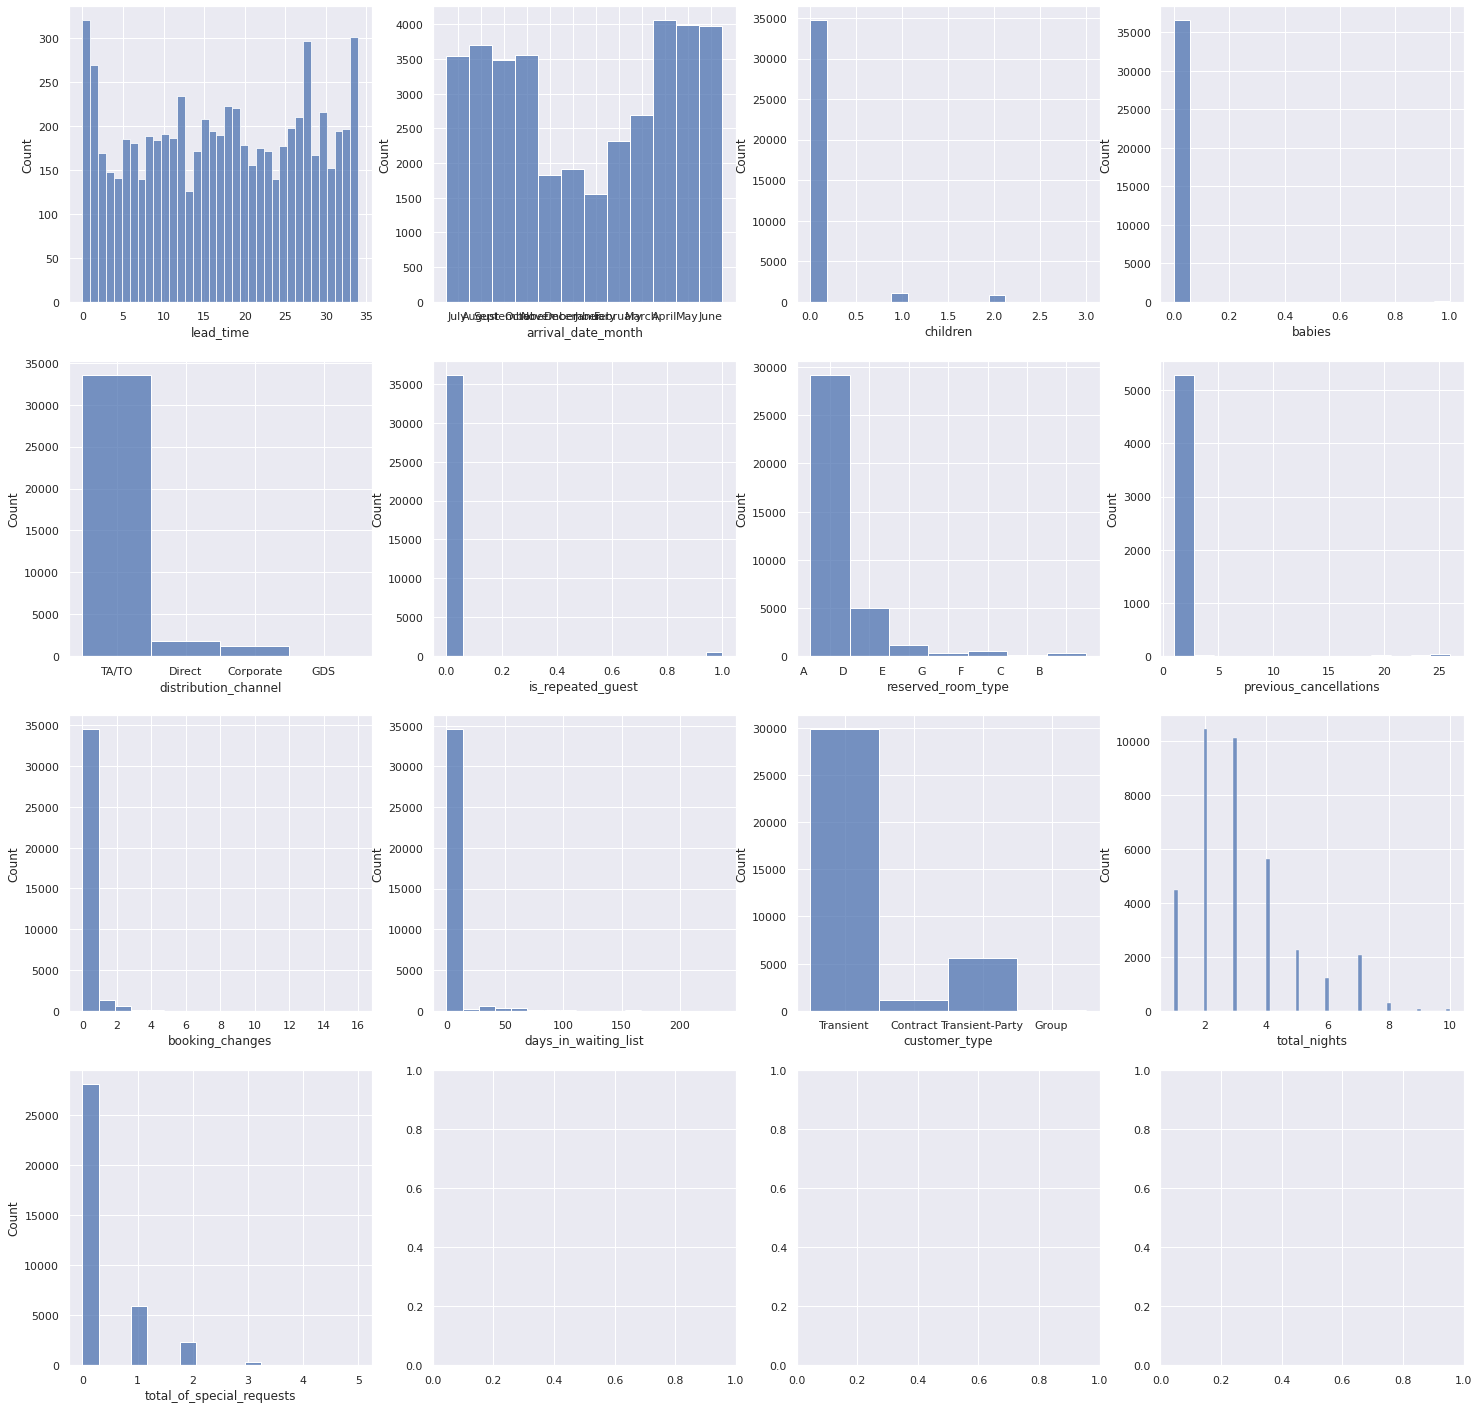

In [44]:
fig, axs = plt.subplots(4, 4, figsize=(25, 25))

sns.histplot(data=data_cancelled.query("lead_time<35"),x='lead_time',bins=35, ax=axs[0, 0]);
sns.histplot(data=data_cancelled,x='arrival_date_month', ax=axs[0, 1]);
sns.histplot(data=data_cancelled,x='children', ax=axs[0, 2]);
sns.histplot(data=data_cancelled,x='babies', ax=axs[0, 3]);
sns.histplot(data=data_cancelled,x='distribution_channel', ax=axs[1, 0]);
sns.histplot(data=data_cancelled,x='is_repeated_guest', ax=axs[1, 1]);
sns.histplot(data=data_cancelled,x='reserved_room_type', ax=axs[1, 2]);
sns.histplot(data=data_cancelled.query('previous_cancellations>0'),x='previous_cancellations',ax=axs[1, 3]);
sns.histplot(data=data_cancelled,x='booking_changes',ax=axs[2, 0]);
sns.histplot(data=data_cancelled,x='days_in_waiting_list',ax=axs[2, 1]);
sns.histplot(data=data_cancelled,x='customer_type',ax=axs[2, 2]);
sns.histplot(data=data_cancelled,x='total_nights',ax=axs[2, 3]);
sns.histplot(data=data_cancelled,x='total_of_special_requests',ax=axs[3, 0]); 

В результате анализа видим, что с достаточно большой вероятностью у клиента, который отменит бронирование:
* Пристутствуют отмены брони в прошлом
* Прошло более недели между бронированием и прибытием
* Не было с собой младенцев и детей до 3 лет
* Бронирование было оформлено в первый раз (не было подтверждённых заказов ранее) 
* Не было изменений параметров бронирования
* Отсутствовали особые пожелания к номеру
* Заезд планировался в период с начала весны до октября

# Выводы

Наиболее качественной оказалась модель случайного леса. За тестовый период внедрение данной модели более чем окупается, принося прибыль более 920 тыс. при бюджете на разработку в 400 тыс. При этом отсутствует эксцесс с количеством предложений клиентам о внесении депозита, так как основной метрикой моделей была выбрана `F-1`, учитывающая также и то, насколько точными будут предсказания об отмене бронирования. Благодаря этому у сети не будет сильного риска, что лояльность клиентов снизится, а количество людей, отменивших бронирование из-за наличия депозита, будет велико.

Для большей оптимизации и налаживания бизнеса данной сети отелей можно порекомендовать следующее:
1. Уменьшить время подтверждения заказов, что положительно скажется на уменьшении количества ненадёжных клиентов
2. Учесть клиентов, отменивших бронирования несколько десятков раз (!), либо ошибка в сборе данных, либо злоумышленники
3. Рассмотреть возможность расширить свои территориальные и дистрибутивные рынки присутствия. Большинство клиентов - граждане Португалии, большая часть бронирований проходит через турагенства.